In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob as gb
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


In [2]:
# Loading labels
dataset = "HAM10000_dataset/"
label_path = dataset + "GroundTruth.csv"
mask_dir = dataset+"masks/"
images_dir = dataset + "images/"
img_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".jpg")])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])

In [3]:
image_names = [os.path.splitext(f)[0] for f in img_files]    # ('ISIC_0024306', '.jpg')
mask_names = [os.path.splitext(f)[0].replace('_segmentation', '') for f in mask_files]    # ('ISIC_0024306_segmentation', 'png')

missing_masks = [f for f in image_names if f not in mask_names]

if len(missing_masks) == 0:
    print('No missing masks found.')
else:
    print(f"There are {len(missing_masks)} missing masks found:")
    print(missing_masks)

No missing masks found.


In [4]:
len(img_files), len(mask_files)

(10015, 10015)

In [5]:


def display_image_and_mask(n=5, seed=None):
    if seed:
        np.random.seed(seed)

    fig, axs = plt.subplots(2, n, figsize=(20, 6))
    for i in range(n):
        idx = np.random.randint(0, len(img_files))
        img_path = os.path.join(images_dir, img_files[idx])
        mask_path = os.path.join(mask_dir, os.path.splitext(img_files[idx])[0] + '_segmentation.png')    # mask_files[idx]

        img = Image.open(img_path)
        mask = Image.open(mask_path)

        axs[0, i].imshow(img)
        axs[0, i].set_title('Image')
        axs[0, i].axis('off')

        axs[1, i].imshow(mask)
        axs[1, i].set_title('Mask')
        axs[1, i].axis('off')

plt.show()

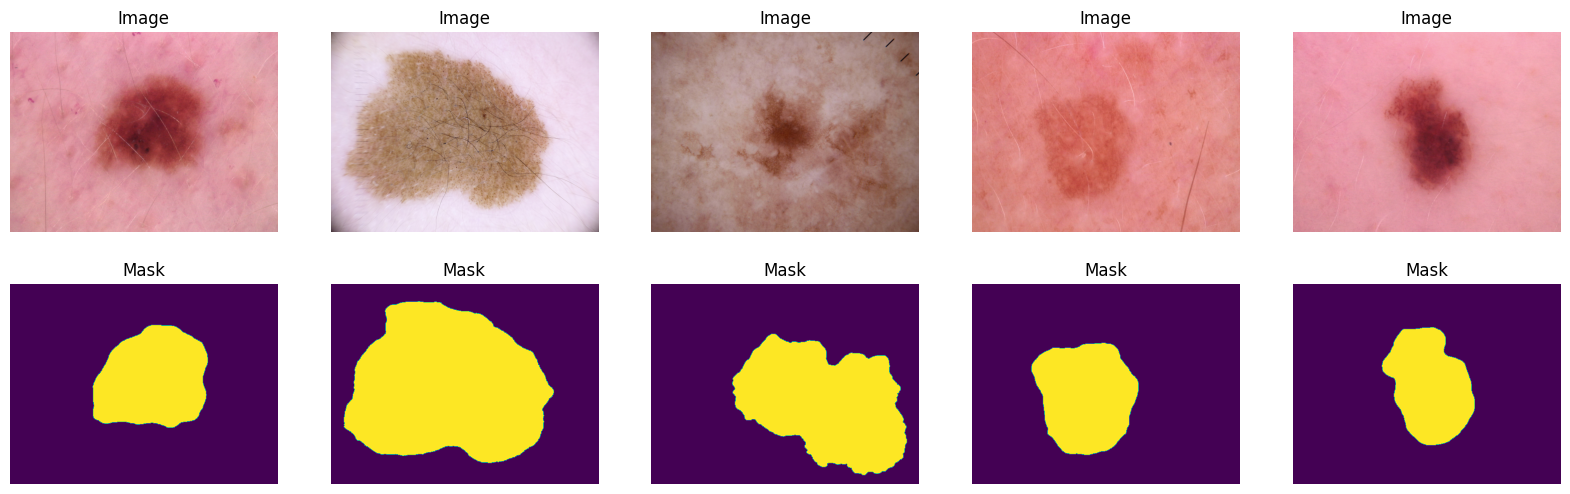

In [6]:
display_image_and_mask(n=5, seed=42)

In [7]:
def display_image_with_mask(n=5, seed=None):
    if seed:
        np.random.seed(seed)

    fig, axs = plt.subplots(1, n, figsize=(20, 5))
    for i in range(n):
        idx = np.random.randint(0, len(img_files))
        img_path = os.path.join(images_dir, img_files[idx])
        mask_path = os.path.join(mask_dir, os.path.splitext(img_files[idx])[0] + '_segmentation.png')    # mask_files[idx]

        img_np = np.array(Image.open(img_path))
        mask_np = np.array(Image.open(mask_path))

        axs[i].imshow(img_np)
        axs[i].imshow(mask_np, cmap='Reds', alpha=0.5)
        axs[i].set_title('Image with Mask')
        axs[i].axis('off')

plt.show()

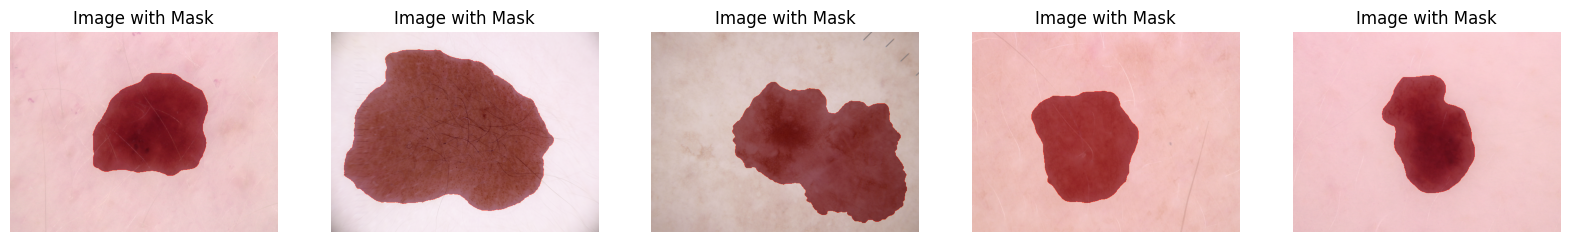

In [8]:
display_image_with_mask(n=5, seed=42)

In [9]:
def img_mask_paths(img_dir, mask_dir):
    img_path = sorted(gb.glob(os.path.join(img_dir, '*.jpg')))
    mask_path = sorted(gb.glob(os.path.join(mask_dir, '*.png')))
    return np.array(img_path), np.array(mask_path)

imgs_path, masks_path = img_mask_paths(images_dir, mask_dir)

In [10]:
# Load the dataset
dataset = "HAM10000_dataset/"
label_path = os.path.join(dataset, "GroundTruth.csv")
labels_df = pd.read_csv(label_path)

In [11]:
# Create a new column 'class' that contains the class label
labels_df['class'] = labels_df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1)


In [12]:
# Split dataset
train_df, temp_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'])


In [13]:
# Function to save splits
def save_split(df, split_name):
    os.makedirs(split_name, exist_ok=True)
    for _, row in df.iterrows():
        shutil.copy(f'HAM10000_dataset/images/{row["image"]}.jpg', f'{split_name}/{row["image"]}.jpg')
        shutil.copy(f'HAM10000_dataset/masks/{row["image"]}_segmentation.png', f'{split_name}/{row["image"]}_mask.png')
# Save the splits
save_split(train_df, 'train')
save_split(val_df, 'val')
save_split(test_df, 'test')


In [14]:
print(f'Train: {len(train_df)} samples')
print(f'Validation: {len(val_df)} samples')
print(f'Test: {len(test_df)} samples')

Train: 8012 samples
Validation: 1001 samples
Test: 1002 samples


In [15]:

# Resize images and masks
resize_transform = transforms.Resize((128, 128))

def resize_and_save(split_name):
    img_dir = os.path.join(split_name, 'images')
    mask_dir = os.path.join(split_name, 'masks')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    for img_file in os.listdir(split_name):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(split_name, img_file)
            mask_path = os.path.join(split_name, img_file.replace('.jpg', '_mask.png'))

            img = Image.open(img_path)
            mask = Image.open(mask_path)

            img_resized = resize_transform(img)
            mask_resized = resize_transform(mask)

            img_resized.save(os.path.join(img_dir, img_file))
            mask_resized.save(os.path.join(mask_dir, img_file.replace('.jpg', '_mask.png')))

resize_and_save('train')
resize_and_save('val')
resize_and_save('test')

In [16]:
# Convert images to tensors and normalize pixel values
class HAM10k(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        mask_path = os.path.join(self.mask_dir, self.img_files[idx].replace('.jpg', '_mask.png'))

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [17]:
# Data Augmentation
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [18]:
# Create PyTorch Dataset and DataLoader
train_dataset = HAM10k('train/images', 'train/masks', transform=data_transforms)
val_dataset = HAM10k('val/images', 'val/masks', transform=data_transforms)
test_dataset = HAM10k('test/images', 'test/masks', transform=data_transforms)


In [19]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)